## Create bulks of data for checking how the model updates

## Different Models

In [13]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier, Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

In [14]:
# Here are some classifiers that support the `partial_fit` method
partial_fit_classifiers = {
    'SGD': SGDClassifier(),
    'ASGD': SGDClassifier(average=True),
    'Perceptron': Perceptron(),
    "Passive-Aggressive I":PassiveAggressiveClassifier(loss='hinge', C=1.0, tol=1e-4),
    "Passive-Aggressive II":PassiveAggressiveClassifier(loss='squared_hinge', C=1.0, tol=1e-4),
}

In [15]:
data_path = 'data.csv'
data_full = pd.read_csv(data_path,header=None,index_col=0)
data_full.columns = ['competence','network_ability','promoted']
#data, test = train_test_split(data_full, test_size=0.2)

In [16]:
def stream_bulks(dataset_df, bulk_size=100000):
    """Iterate over bulks of the dataset."""
    for i in range(0,len(dataset_df),bulk_size):
        vals = dataset_df.iloc[i:i+bulk_size].to_numpy()
        yield vals[:,:-1], vals[:,-1]

In [17]:
all_classes = np.array([0, 1])

In [18]:
# test data statistics
test_stats = {'n_test': 0, 'n_test_pos': 0}

# First we hold out a number of examples to estimate accuracy
n_test_documents = 1000
tick = time.time()
X_test, y_test = [i for i in stream_bulks(data_full)][0]
parsing_time = time.time() - tick
vectorizing_time = time.time() - tick
tick = time.time()
test_stats['n_test'] += len(y_test)
test_stats['n_test_pos'] += sum(y_test)
print("Test set is %d documents (%d positive)" % (len(y_test), sum(y_test)))

Test set is 100000 documents (31399 positive)


In [19]:
def progress(cls_name, stats):
    """Report progress information, return a string."""
    duration = time.time() - stats['t0']
    s = "%20s classifier : \t" % cls_name
    s += "%(n_train)6d train docs (%(n_train_pos)6d positive) " % stats
    s += "%(n_test)6d test docs (%(n_test_pos)6d positive) " % test_stats
    s += "accuracy: %(accuracy).3f " % stats
    s += "in %.2fs (%5d docs/s)" % (duration, stats['n_train'] / duration)
    return s

In [20]:
cls_stats = {}
for cls_name in partial_fit_classifiers:
    stats = {'n_train': 0, 'n_train_pos': 0,
             'accuracy': 0.0, 'accuracy_history': [(0, 0)], 't0': time.time(),
             'runtime_history': [(0, 0)], 'total_fit_time': 0.0}
    cls_stats[cls_name] = stats

## Process bulk by bulk

In [21]:
total_vect_time = 0.0

# Main loop : iterate on mini-batchs of examples
for i, (X_train, y_train) in enumerate(stream_bulks(data_full)):
    if i == 0 :
        continue
    tick = time.time()
    total_vect_time += time.time() - tick

    for cls_name, cls in partial_fit_classifiers.items():
        tick = time.time()
        
        # update estimator with examples in the current mini-batch
        cls.partial_fit(X_train, y_train, classes=all_classes)

        # accumulate test accuracy stats
        cls_stats[cls_name]['total_fit_time'] += time.time() - tick
        cls_stats[cls_name]['n_train'] += X_train.shape[0]
        cls_stats[cls_name]['n_train_pos'] += sum(y_train)
        tick = time.time()
        cls_stats[cls_name]['accuracy'] = cls.score(X_test, y_test)
        cls_stats[cls_name]['prediction_time'] = time.time() - tick
        acc_history = (cls_stats[cls_name]['accuracy'],
                       cls_stats[cls_name]['n_train'])
        cls_stats[cls_name]['accuracy_history'].append(acc_history)
        run_history = (cls_stats[cls_name]['accuracy'],
                       total_vect_time + cls_stats[cls_name]['total_fit_time'])
        cls_stats[cls_name]['runtime_history'].append(run_history)

        if i % 3 == 0:
            print(progress(cls_name, cls_stats[cls_name]))
    if i % 3 == 0:
        print('\n')

                 SGD classifier : 	300000 train docs ( 93973 positive) 100000 test docs ( 31399 positive) accuracy: 0.811 in 3.59s (83515 docs/s)
                ASGD classifier : 	300000 train docs ( 93973 positive) 100000 test docs ( 31399 positive) accuracy: 0.814 in 3.75s (79906 docs/s)
          Perceptron classifier : 	300000 train docs ( 93973 positive) 100000 test docs ( 31399 positive) accuracy: 0.711 in 3.94s (76122 docs/s)
Passive-Aggressive I classifier : 	300000 train docs ( 93973 positive) 100000 test docs ( 31399 positive) accuracy: 0.712 in 4.24s (70771 docs/s)
Passive-Aggressive II classifier : 	300000 train docs ( 93973 positive) 100000 test docs ( 31399 positive) accuracy: 0.818 in 4.43s (67673 docs/s)


                 SGD classifier : 	600000 train docs (187692 positive) 100000 test docs ( 31399 positive) accuracy: 0.814 in 6.85s (87527 docs/s)
                ASGD classifier : 	600000 train docs (187692 positive) 100000 test docs ( 31399 positive) accuracy: 0.815

In [22]:
cls_stats

{'SGD': {'n_train': 900000,
  'n_train_pos': 281603.0,
  'accuracy': 0.81491,
  'accuracy_history': [(0, 0),
   (0.81228, 100000),
   (0.79021, 200000),
   (0.81072, 300000),
   (0.81527, 400000),
   (0.81429, 500000),
   (0.81449, 600000),
   (0.81478, 700000),
   (0.81489, 800000),
   (0.81491, 900000)],
  't0': 1622135854.7290442,
  'runtime_history': [(0, 0),
   (0.81228, 0.08129215240478516),
   (0.79021, 0.15877532958984375),
   (0.81072, 0.2824079990386963),
   (0.81527, 0.3822000026702881),
   (0.81429, 0.4565105438232422),
   (0.81449, 0.5621347427368164),
   (0.81478, 0.6758506298065186),
   (0.81489, 0.745100736618042),
   (0.81491, 0.8124444484710693)],
  'total_fit_time': 0.8124325275421143,
  'prediction_time': 0.021991491317749023},
 'ASGD': {'n_train': 900000,
  'n_train_pos': 281603.0,
  'accuracy': 0.81477,
  'accuracy_history': [(0, 0),
   (0.81424, 100000),
   (0.81441, 200000),
   (0.81443, 300000),
   (0.81458, 400000),
   (0.81462, 500000),
   (0.81461, 600000),


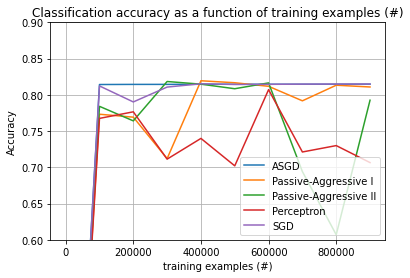

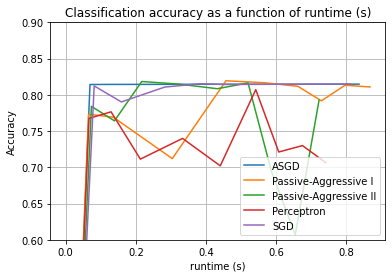

In [23]:
###############################################################################
# Plot results
###############################################################################
def plot_accuracy(x, y, x_legend):
    """Plot accuracy as a function of x."""
    x = np.array(x)
    y = np.array(y)
    plt.title('Classification accuracy as a function of %s' % x_legend)
    plt.xlabel('%s' % x_legend)
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.plot(x, y)

rcParams['legend.fontsize'] = 10
cls_names = list(sorted(cls_stats.keys()))

# Plot accuracy evolution
plt.figure()
for _, stats in sorted(cls_stats.items()):
    # Plot accuracy evolution with #examples
    accuracy, n_examples = zip(*stats['accuracy_history'])
    plot_accuracy(n_examples, accuracy, "training examples (#)")
    ax = plt.gca()
    ax.set_ylim((0.6, 0.9))
plt.legend(cls_names, loc='best')

plt.figure()
for _, stats in sorted(cls_stats.items()):
    # Plot accuracy evolution with runtime
    accuracy, runtime = zip(*stats['runtime_history'])
    plot_accuracy(runtime, accuracy, 'runtime (s)')
    ax = plt.gca()
    ax.set_ylim((0.6, 0.9))
plt.legend(cls_names, loc='best')


In [11]:
colors = ["#348ABD", "#A60628", "#7A68A6", "#467821","#348ABD", "#A60628", "#7A68A6", "#467821"]


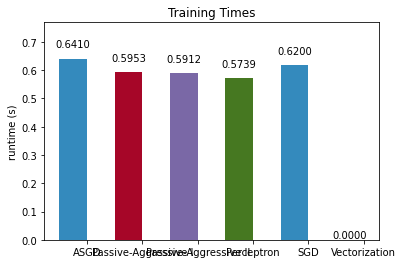

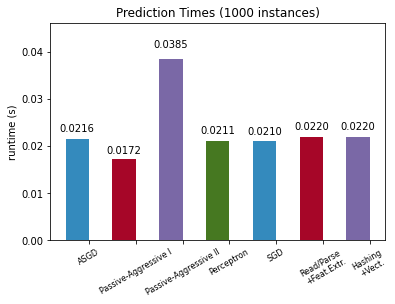

In [12]:
# Plot fitting times
plt.figure()
fig = plt.gcf()
cls_runtime = []
for cls_name, stats in sorted(cls_stats.items()):
    cls_runtime.append(stats['total_fit_time'])

cls_runtime.append(total_vect_time)
cls_names.append('Vectorization')
bar_colors =  colors[:len(cls_names)]

ax = plt.subplot(111)
rectangles = plt.bar(range(len(cls_names)), cls_runtime, width=0.5,
                     color=bar_colors)

ax.set_xticks(np.linspace(0.25, len(cls_names) - 0.75, len(cls_names)))
ax.set_xticklabels(cls_names, fontsize=10)
#plt.setp(plt.xticks()[1], rotation=30)
ymax = max(cls_runtime) * 1.2
ax.set_ylim((0, ymax))
ax.set_ylabel('runtime (s)')
ax.set_title('Training Times')


def autolabel(rectangles):
    """attach some text vi autolabel on rectangles."""
    for rect in rectangles:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2.,
                1.05 * height, '%.4f' % height,
                ha='center', va='bottom')

autolabel(rectangles)
plt.show()

# Plot prediction times
plt.figure()
#fig = plt.gcf()
cls_runtime = []
cls_names = list(sorted(cls_stats.keys()))
for cls_name, stats in sorted(cls_stats.items()):
    cls_runtime.append(stats['prediction_time'])
cls_runtime.append(parsing_time)
cls_names.append('Read/Parse\n+Feat.Extr.')
cls_runtime.append(vectorizing_time)
cls_names.append('Hashing\n+Vect.')
bar_colors =  colors[:len(cls_names)]

ax = plt.subplot(111)
rectangles = plt.bar(range(len(cls_names)), cls_runtime, width=0.5,
                     color=bar_colors)

ax.set_xticks(np.linspace(0.25, len(cls_names) - 0.75, len(cls_names)))
ax.set_xticklabels(cls_names, fontsize=8)
plt.setp(plt.xticks()[1], rotation=30)
ymax = max(cls_runtime) * 1.2
ax.set_ylim((0, ymax))
ax.set_ylabel('runtime (s)')
ax.set_title('Prediction Times (%d instances)' % n_test_documents)
autolabel(rectangles)
plt.show()